<div style='float: right'><img src='pic/nonogram.png'/></div>

# <div id='nonogram' />Nonogram

## 1. ライブラリのインポート

In [1]:
#!pip3 install pulp ortoolpy
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from pulp import LpProblem, lpSum, value
from ortoolpy import addvars, addbinvars

## 2. 入力(与えられているヒント)の定義

In [2]:
# 5×5
# 行に対してのヒント
row = [[int(s) for s in t.split(',')] for t in
         '3 2,2 1,1 2,2 3'.split()]
# 列に対してのヒント
column = [[int(s) for s in t.split(',')] for t in
         '3 2,2 1,1 2,2 3'.split()]

### 2.1 行に対してのヒント

In [7]:
row

[[3], [2, 2], [1, 1], [2, 2], [3]]

### 2.2 列に対してのヒント

In [8]:
column

[[3], [2, 2], [1, 1], [2, 2], [3]]

### 2.3 問題のサイズ

In [9]:
print('Size: ',len(row),'×',len(column))

Size:  5 × 5


## 3. 解を求める

### 3.1 解候補を作成する関数

In [10]:
def makelist(i, j, k):
    return [0] * i + [1] * j + [0] * k # 0がi個、1がj個、0がk個並んだ配列を返す
# ex) [0]*4+[1]*3+[0]*2 → [0, 0, 0, 0, 1, 1, 1, 0, 0]

#### 実行例

In [11]:
n=6
p=2
[makelist(i, p, n - p - i) for i in range(n - p + 1)]

[[1, 1, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0],
 [0, 0, 1, 1, 0, 0],
 [0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 1, 1]]

### 3.2 各行(列)における解候補を列挙したリストを作成する

In [12]:
def sol_list(n, l):
    p = l[-1]
    if len(l) == 1:
        if n < p: return None
        return [makelist(i, p, n - p - i) for i in range(n - p + 1)]
    ll = l[:-1]
    s = sum(ll) + len(ll) - 1
    return [j + makelist(1, p, n - p - s - i - 1) \
        for i in range(n - p - s) for j in sol_list(i + s, ll)]

#### 実行例

In [13]:
for i, hh in enumerate(column):
        l = sol_list(len(column), hh) # (vの列数, ヒントの内容)
        print(l)
        print('--')
# column: [[3], [2, 2], [1, 1], [2, 2], [3]]

[[1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 1, 1]]
--
[[1, 1, 0, 1, 1]]
--
[[1, 0, 1, 0, 0], [1, 0, 0, 1, 0], [0, 1, 0, 1, 0], [1, 0, 0, 0, 1], [0, 1, 0, 0, 1], [0, 0, 1, 0, 1]]
--
[[1, 1, 0, 1, 1]]
--
[[1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 1, 1]]
--


### 3.3 制約条件、目的関数の定義

In [14]:
def do(m, v, hint):
    for i, hh in enumerate(hint):
        l = sol_list(v.shape[0], hh) # 引数：(問題のサイズ, ヒントの内容)→各行(列)に対する解候補を列挙したリストを作成
        r = addbinvars(len(l)) # 𝑟𝑘∈{0,1} ∀𝑘,行または列   行(列)ごとに解候補を列挙したリスト内の𝑘番目の候補を選ぶかどうか　1→選ぶ
        m += lpSum(r) == 1 # ∑𝑘𝑟𝑘=1 ∀行または列    行または列ごとに候補の中から1つ選ぶ
        for j, c in enumerate(l):
            for k, b in enumerate(c):
                m += (1 - 2 * b) * v[k,i] <= 1 - b - r[j] # 候補を選んだ通りにマスの色を塗る

## 4. 最適化の実行

In [16]:
m = LpProblem()
v = np.array(addvars(len(row), len(column))) # 𝑣𝑖𝑗∈{0,1} ∀𝑖,𝑗   マス𝑖,𝑗が黒かどうか
do(m, v, row) # 列について
do(m, v.T, column) # 行について
# %timeit -n5 m.solve()
%time m.solve()
# m.solve()

CPU times: user 2.79 ms, sys: 4.3 ms, total: 7.09 ms
Wall time: 35.7 ms


1

### 結果の表示

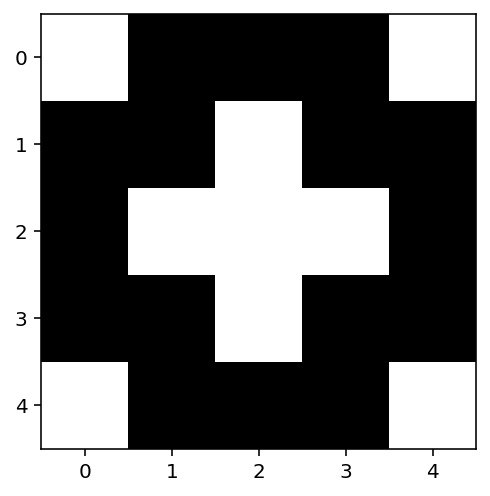

In [17]:
%config InlineBackend.figure_formats={'png','retina'}
plt.imshow(1-np.vectorize(value)(v), cmap='gray', interpolation='none');